In [2]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

d:\Projects\Machine_Learning\OTHER_ML\SHAP-PROJECT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [3]:
from sklearn import set_config
set_config(
    transform_output="pandas",
    display="diagram"
)


In [4]:
data = fetch_california_housing(as_frame=True)

In [5]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [6]:
x, y = data.data, data.target

In [7]:
# columns names
feature_names = data.feature_names
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [8]:
x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y.head

<bound method NDFrame.head of 0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model

In [11]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

In [12]:
# fit the model
xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [13]:
# calculate predictions
y_pred_test = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)
# evaluate the model
rmse_test = root_mean_squared_error(y_test, y_pred_test)
rmse_train = root_mean_squared_error(y_train, y_pred_train)

r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
print(f"Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}")
print(f"Train R2: {r2_train:.4f}, Test R2: {r2_test:.4f}")

Train RMSE: 0.4226, Test RMSE: 0.4936
Train R2: 0.8664, Test R2: 0.8141


# HP Tuning

In [14]:
# tune the model with optuna
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-12-18 22:31:53,462] A new study created in memory with name: no-name-e11c2171-a97f-4131-b233-f3c5fe5c3ffb
Best trial: 0. Best value: 0.445062:   2%|▏         | 1/50 [00:01<01:14,  1.51s/it]

[I 2025-12-18 22:31:54,977] Trial 0 finished with value: 0.44506179024115256 and parameters: {'n_estimators': 279, 'learning_rate': 0.04699277892118889, 'max_depth': 9, 'subsample': 0.7583009119717208, 'colsample_bytree': 0.7850146149698436}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:   4%|▍         | 2/50 [00:01<00:37,  1.30it/s]

[I 2025-12-18 22:31:55,225] Trial 1 finished with value: 0.48002748303225606 and parameters: {'n_estimators': 144, 'learning_rate': 0.07868047136953601, 'max_depth': 5, 'subsample': 0.6371830948141017, 'colsample_bytree': 0.7985131159808485}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:   6%|▌         | 3/50 [00:02<00:25,  1.87it/s]

[I 2025-12-18 22:31:55,478] Trial 2 finished with value: 0.5046158888422021 and parameters: {'n_estimators': 148, 'learning_rate': 0.0910395856991432, 'max_depth': 4, 'subsample': 0.7835808484063276, 'colsample_bytree': 0.5712182292787282}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:   8%|▊         | 4/50 [00:02<00:20,  2.28it/s]

[I 2025-12-18 22:31:55,773] Trial 3 finished with value: 0.45802459267763374 and parameters: {'n_estimators': 194, 'learning_rate': 0.1901794249581899, 'max_depth': 5, 'subsample': 0.7364841728179125, 'colsample_bytree': 0.8970620042815904}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  12%|█▏        | 6/50 [00:03<00:16,  2.63it/s]

[I 2025-12-18 22:31:56,331] Trial 4 finished with value: 0.45850255211185736 and parameters: {'n_estimators': 157, 'learning_rate': 0.08296365208557997, 'max_depth': 8, 'subsample': 0.6390220200454342, 'colsample_bytree': 0.6922464022262379}. Best is trial 0 with value: 0.44506179024115256.
[I 2025-12-18 22:31:56,512] Trial 5 finished with value: 0.5756857890989371 and parameters: {'n_estimators': 119, 'learning_rate': 0.028422066200568828, 'max_depth': 4, 'subsample': 0.9653850614014947, 'colsample_bytree': 0.9427934243622786}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  14%|█▍        | 7/50 [00:04<00:28,  1.49it/s]

[I 2025-12-18 22:31:57,789] Trial 6 finished with value: 0.47026605797866305 and parameters: {'n_estimators': 144, 'learning_rate': 0.0662836433714641, 'max_depth': 10, 'subsample': 0.6397551915757702, 'colsample_bytree': 0.5199774984825835}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  16%|█▌        | 8/50 [00:04<00:27,  1.52it/s]

[I 2025-12-18 22:31:58,416] Trial 7 finished with value: 0.4722848544563068 and parameters: {'n_estimators': 226, 'learning_rate': 0.21365520720164174, 'max_depth': 6, 'subsample': 0.6007402171815519, 'colsample_bytree': 0.8753840798741694}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  18%|█▊        | 9/50 [00:05<00:27,  1.51it/s]

[I 2025-12-18 22:31:59,087] Trial 8 finished with value: 0.4587718011045173 and parameters: {'n_estimators': 218, 'learning_rate': 0.12874685423858992, 'max_depth': 7, 'subsample': 0.7577770373894235, 'colsample_bytree': 0.5479446913619279}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  20%|██        | 10/50 [00:05<00:22,  1.81it/s]

[I 2025-12-18 22:31:59,395] Trial 9 finished with value: 0.4685408908435626 and parameters: {'n_estimators': 148, 'learning_rate': 0.24297205814809386, 'max_depth': 5, 'subsample': 0.9081708522760573, 'colsample_bytree': 0.6215469964508048}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  22%|██▏       | 11/50 [00:09<00:55,  1.42s/it]

[I 2025-12-18 22:32:02,773] Trial 10 finished with value: 0.47019881908282996 and parameters: {'n_estimators': 290, 'learning_rate': 0.012539846476105662, 'max_depth': 10, 'subsample': 0.5197130473639837, 'colsample_bytree': 0.774618615859745}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  24%|██▍       | 12/50 [00:09<00:42,  1.12s/it]

[I 2025-12-18 22:32:03,221] Trial 11 finished with value: 0.4724037420862145 and parameters: {'n_estimators': 52, 'learning_rate': 0.18135793978433548, 'max_depth': 8, 'subsample': 0.804793497226217, 'colsample_bytree': 0.9984450969553836}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  26%|██▌       | 13/50 [00:10<00:32,  1.14it/s]

[I 2025-12-18 22:32:03,525] Trial 12 finished with value: 0.47752590011286167 and parameters: {'n_estimators': 296, 'learning_rate': 0.2953327565262507, 'max_depth': 3, 'subsample': 0.8902656584108746, 'colsample_bytree': 0.8551551755699611}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  28%|██▊       | 14/50 [00:11<00:34,  1.06it/s]

[I 2025-12-18 22:32:04,641] Trial 13 finished with value: 0.4570435495015645 and parameters: {'n_estimators': 237, 'learning_rate': 0.1487514508826629, 'max_depth': 8, 'subsample': 0.7180992078758159, 'colsample_bytree': 0.7167236191248797}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  30%|███       | 15/50 [00:13<00:43,  1.25s/it]

[I 2025-12-18 22:32:06,583] Trial 14 finished with value: 0.4597718253820151 and parameters: {'n_estimators': 263, 'learning_rate': 0.1449415446918225, 'max_depth': 9, 'subsample': 0.7167634975936975, 'colsample_bytree': 0.6906624972687359}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  32%|███▏      | 16/50 [00:14<00:42,  1.26s/it]

[I 2025-12-18 22:32:07,883] Trial 15 finished with value: 0.44750278193780846 and parameters: {'n_estimators': 251, 'learning_rate': 0.12749190609733846, 'max_depth': 8, 'subsample': 0.8405905457293016, 'colsample_bytree': 0.6864932149270248}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  34%|███▍      | 17/50 [00:16<00:48,  1.48s/it]

[I 2025-12-18 22:32:09,870] Trial 16 finished with value: 0.4530783243485653 and parameters: {'n_estimators': 272, 'learning_rate': 0.11105339240451727, 'max_depth': 9, 'subsample': 0.844256266631291, 'colsample_bytree': 0.6284054884797692}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  36%|███▌      | 18/50 [00:17<00:39,  1.25s/it]

[I 2025-12-18 22:32:10,582] Trial 17 finished with value: 0.4481480882182249 and parameters: {'n_estimators': 255, 'learning_rate': 0.04585766885747626, 'max_depth': 7, 'subsample': 0.8494638927276537, 'colsample_bytree': 0.8160472559380275}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  38%|███▊      | 19/50 [00:18<00:38,  1.23s/it]

[I 2025-12-18 22:32:11,779] Trial 18 finished with value: 0.4511044070099548 and parameters: {'n_estimators': 190, 'learning_rate': 0.04797943167056963, 'max_depth': 9, 'subsample': 0.956865104813597, 'colsample_bytree': 0.7361792479824842}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  40%|████      | 20/50 [00:20<00:44,  1.50s/it]

[I 2025-12-18 22:32:13,881] Trial 19 finished with value: 0.4500910286703342 and parameters: {'n_estimators': 247, 'learning_rate': 0.10831633575757825, 'max_depth': 10, 'subsample': 0.8327388891338393, 'colsample_bytree': 0.6439198505344569}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  42%|████▏     | 21/50 [00:21<00:38,  1.32s/it]

[I 2025-12-18 22:32:14,808] Trial 20 finished with value: 0.45221070012862313 and parameters: {'n_estimators': 300, 'learning_rate': 0.1706364901448155, 'max_depth': 7, 'subsample': 0.8947915631510927, 'colsample_bytree': 0.8238232182282123}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  44%|████▍     | 22/50 [00:22<00:32,  1.15s/it]

[I 2025-12-18 22:32:15,551] Trial 21 finished with value: 0.4474589100260145 and parameters: {'n_estimators': 266, 'learning_rate': 0.04560145355294787, 'max_depth': 7, 'subsample': 0.8485245105746813, 'colsample_bytree': 0.7687562219140248}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  46%|████▌     | 23/50 [00:23<00:31,  1.16s/it]

[I 2025-12-18 22:32:16,739] Trial 22 finished with value: 0.49885078166301583 and parameters: {'n_estimators': 276, 'learning_rate': 0.010432230197986045, 'max_depth': 8, 'subsample': 0.7913167434697135, 'colsample_bytree': 0.7611230296769517}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  48%|████▊     | 24/50 [00:23<00:24,  1.06it/s]

[I 2025-12-18 22:32:17,162] Trial 23 finished with value: 0.4691040063663358 and parameters: {'n_estimators': 208, 'learning_rate': 0.05146164022049904, 'max_depth': 6, 'subsample': 0.6850981474413353, 'colsample_bytree': 0.669802976996416}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  50%|█████     | 25/50 [00:25<00:27,  1.10s/it]

[I 2025-12-18 22:32:18,645] Trial 24 finished with value: 0.453086937602243 and parameters: {'n_estimators': 243, 'learning_rate': 0.11170817743577874, 'max_depth': 9, 'subsample': 0.9316957804395041, 'colsample_bytree': 0.7403281870155557}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  52%|█████▏    | 26/50 [00:25<00:24,  1.01s/it]

[I 2025-12-18 22:32:19,435] Trial 25 finished with value: 0.4454872408641994 and parameters: {'n_estimators': 273, 'learning_rate': 0.061223784973261516, 'max_depth': 7, 'subsample': 0.8757621963042957, 'colsample_bytree': 0.7785907332962875}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  54%|█████▍    | 27/50 [00:26<00:20,  1.14it/s]

[I 2025-12-18 22:32:19,996] Trial 26 finished with value: 0.47209644379298693 and parameters: {'n_estimators': 279, 'learning_rate': 0.028139586090082186, 'max_depth': 6, 'subsample': 0.8630478259929282, 'colsample_bytree': 0.8464010674773288}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  56%|█████▌    | 28/50 [00:26<00:15,  1.43it/s]

[I 2025-12-18 22:32:20,279] Trial 27 finished with value: 0.4693441830974268 and parameters: {'n_estimators': 87, 'learning_rate': 0.0665195912815463, 'max_depth': 7, 'subsample': 0.9914911204813585, 'colsample_bytree': 0.7767179878288522}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  58%|█████▊    | 29/50 [00:27<00:13,  1.59it/s]

[I 2025-12-18 22:32:20,755] Trial 28 finished with value: 0.48347213728644406 and parameters: {'n_estimators': 224, 'learning_rate': 0.030529547066741474, 'max_depth': 6, 'subsample': 0.8100591703219427, 'colsample_bytree': 0.8911162742897656}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  60%|██████    | 30/50 [00:28<00:13,  1.53it/s]

[I 2025-12-18 22:32:21,466] Trial 29 finished with value: 0.4476355842875328 and parameters: {'n_estimators': 267, 'learning_rate': 0.08818252397023263, 'max_depth': 7, 'subsample': 0.7619103792838468, 'colsample_bytree': 0.7983722045623854}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 0. Best value: 0.445062:  62%|██████▏   | 31/50 [00:29<00:14,  1.28it/s]

[I 2025-12-18 22:32:22,539] Trial 30 finished with value: 0.44844099294356093 and parameters: {'n_estimators': 175, 'learning_rate': 0.050017651340029695, 'max_depth': 9, 'subsample': 0.8744487513516399, 'colsample_bytree': 0.8103609927891484}. Best is trial 0 with value: 0.44506179024115256.


Best trial: 31. Best value: 0.443819:  64%|██████▍   | 32/50 [00:30<00:15,  1.20it/s]

[I 2025-12-18 22:32:23,501] Trial 31 finished with value: 0.44381926049637865 and parameters: {'n_estimators': 255, 'learning_rate': 0.06978300145559321, 'max_depth': 8, 'subsample': 0.8207472851430159, 'colsample_bytree': 0.7177222860168044}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 31. Best value: 0.443819:  66%|██████▌   | 33/50 [00:31<00:15,  1.11it/s]

[I 2025-12-18 22:32:24,568] Trial 32 finished with value: 0.4438197752661385 and parameters: {'n_estimators': 276, 'learning_rate': 0.06438044527447775, 'max_depth': 8, 'subsample': 0.9194111520495984, 'colsample_bytree': 0.723242300004186}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 31. Best value: 0.443819:  68%|██████▊   | 34/50 [00:32<00:15,  1.05it/s]

[I 2025-12-18 22:32:25,636] Trial 33 finished with value: 0.44551834918078403 and parameters: {'n_estimators': 285, 'learning_rate': 0.071503319334431, 'max_depth': 8, 'subsample': 0.9170687517722126, 'colsample_bytree': 0.720253323314913}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 31. Best value: 0.443819:  70%|███████   | 35/50 [00:33<00:15,  1.05s/it]

[I 2025-12-18 22:32:26,925] Trial 34 finished with value: 0.45993887334775746 and parameters: {'n_estimators': 234, 'learning_rate': 0.08908975733526155, 'max_depth': 9, 'subsample': 0.9287795366774889, 'colsample_bytree': 0.592876907366427}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 31. Best value: 0.443819:  72%|███████▏  | 36/50 [00:34<00:13,  1.03it/s]

[I 2025-12-18 22:32:27,692] Trial 35 finished with value: 0.4489035962571814 and parameters: {'n_estimators': 204, 'learning_rate': 0.07047359932718347, 'max_depth': 8, 'subsample': 0.7797919224950562, 'colsample_bytree': 0.7144080745843474}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 31. Best value: 0.443819:  74%|███████▍  | 37/50 [00:36<00:18,  1.43s/it]

[I 2025-12-18 22:32:30,203] Trial 36 finished with value: 0.455028555110363 and parameters: {'n_estimators': 283, 'learning_rate': 0.09370137828223096, 'max_depth': 10, 'subsample': 0.818645227888759, 'colsample_bytree': 0.9289343572222046}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 31. Best value: 0.443819:  76%|███████▌  | 38/50 [00:37<00:15,  1.29s/it]

[I 2025-12-18 22:32:31,156] Trial 37 finished with value: 0.4543861956205546 and parameters: {'n_estimators': 255, 'learning_rate': 0.029650140726768193, 'max_depth': 8, 'subsample': 0.9547632010207976, 'colsample_bytree': 0.6672055071487504}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 31. Best value: 0.443819:  78%|███████▊  | 39/50 [00:39<00:15,  1.43s/it]

[I 2025-12-18 22:32:32,916] Trial 38 finished with value: 0.44622555425817856 and parameters: {'n_estimators': 298, 'learning_rate': 0.06395594766019308, 'max_depth': 9, 'subsample': 0.9997094017315895, 'colsample_bytree': 0.7880540281039576}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 31. Best value: 0.443819:  80%|████████  | 40/50 [00:39<00:10,  1.07s/it]

[I 2025-12-18 22:32:33,158] Trial 39 finished with value: 0.4907019391976467 and parameters: {'n_estimators': 181, 'learning_rate': 0.10016221927418009, 'max_depth': 4, 'subsample': 0.6772306337299066, 'colsample_bytree': 0.7399373063262038}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 31. Best value: 0.443819:  82%|████████▏ | 41/50 [00:40<00:07,  1.13it/s]

[I 2025-12-18 22:32:33,614] Trial 40 finished with value: 0.46814064858766086 and parameters: {'n_estimators': 216, 'learning_rate': 0.07997933687144829, 'max_depth': 5, 'subsample': 0.8759610374995928, 'colsample_bytree': 0.84175409044962}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 31. Best value: 0.443819:  84%|████████▍ | 42/50 [00:41<00:07,  1.06it/s]

[I 2025-12-18 22:32:34,692] Trial 41 finished with value: 0.444258795721099 and parameters: {'n_estimators': 285, 'learning_rate': 0.06162360711900889, 'max_depth': 8, 'subsample': 0.9303305938501213, 'colsample_bytree': 0.7111689334184523}. Best is trial 31 with value: 0.44381926049637865.


Best trial: 42. Best value: 0.443119:  86%|████████▌ | 43/50 [00:42<00:06,  1.01it/s]

[I 2025-12-18 22:32:35,775] Trial 42 finished with value: 0.44311865734175016 and parameters: {'n_estimators': 284, 'learning_rate': 0.05875810679124178, 'max_depth': 8, 'subsample': 0.9660739757693135, 'colsample_bytree': 0.7068525680452513}. Best is trial 42 with value: 0.44311865734175016.


Best trial: 42. Best value: 0.443119:  88%|████████▊ | 44/50 [00:43<00:06,  1.02s/it]

[I 2025-12-18 22:32:36,870] Trial 43 finished with value: 0.4479500977918378 and parameters: {'n_estimators': 289, 'learning_rate': 0.035247544378403814, 'max_depth': 8, 'subsample': 0.9727117659412006, 'colsample_bytree': 0.6534220667739338}. Best is trial 42 with value: 0.44311865734175016.


Best trial: 42. Best value: 0.443119:  90%|█████████ | 45/50 [00:45<00:06,  1.37s/it]

[I 2025-12-18 22:32:39,070] Trial 44 finished with value: 0.4802738201839844 and parameters: {'n_estimators': 265, 'learning_rate': 0.13057828469584423, 'max_depth': 10, 'subsample': 0.9436953999043958, 'colsample_bytree': 0.603585504655178}. Best is trial 42 with value: 0.44311865734175016.


Best trial: 42. Best value: 0.443119:  92%|█████████▏| 46/50 [00:47<00:05,  1.48s/it]

[I 2025-12-18 22:32:40,808] Trial 45 finished with value: 0.4447749331336279 and parameters: {'n_estimators': 286, 'learning_rate': 0.0772686311615734, 'max_depth': 9, 'subsample': 0.9770701624078331, 'colsample_bytree': 0.7047460560019062}. Best is trial 42 with value: 0.44311865734175016.


Best trial: 42. Best value: 0.443119:  94%|█████████▍| 47/50 [00:49<00:04,  1.55s/it]

[I 2025-12-18 22:32:42,521] Trial 46 finished with value: 0.44830051484036526 and parameters: {'n_estimators': 300, 'learning_rate': 0.07897661584379827, 'max_depth': 9, 'subsample': 0.9797195014359595, 'colsample_bytree': 0.7040275510441258}. Best is trial 42 with value: 0.44311865734175016.


Best trial: 42. Best value: 0.443119:  96%|█████████▌| 48/50 [00:50<00:02,  1.41s/it]

[I 2025-12-18 22:32:43,602] Trial 47 finished with value: 0.46334988948486533 and parameters: {'n_estimators': 286, 'learning_rate': 0.2117459384470214, 'max_depth': 8, 'subsample': 0.906370956747437, 'colsample_bytree': 0.6859312667621111}. Best is trial 42 with value: 0.44311865734175016.


Best trial: 42. Best value: 0.443119:  98%|█████████▊| 49/50 [00:50<00:01,  1.23s/it]

[I 2025-12-18 22:32:44,421] Trial 48 finished with value: 0.514549592133445 and parameters: {'n_estimators': 122, 'learning_rate': 0.019560372009386005, 'max_depth': 9, 'subsample': 0.9374659922231224, 'colsample_bytree': 0.7477264230196755}. Best is trial 42 with value: 0.44311865734175016.


Best trial: 42. Best value: 0.443119: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it]

[I 2025-12-18 22:32:45,508] Trial 49 finished with value: 0.4520414767117414 and parameters: {'n_estimators': 260, 'learning_rate': 0.12165408262214396, 'max_depth': 8, 'subsample': 0.972436201779823, 'colsample_bytree': 0.565080151358371}. Best is trial 42 with value: 0.44311865734175016.


In [16]:
study.best_params

{'n_estimators': 284,
 'learning_rate': 0.05875810679124178,
 'max_depth': 8,
 'subsample': 0.9660739757693135,
 'colsample_bytree': 0.7068525680452513}

In [17]:
study.best_value

0.44311865734175016

In [18]:
best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7068525680452513
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import

In [19]:
# print the metrics
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
print(f"Best Model Train RMSE: {rmse_train:.4f}", f"Best Model Train R2: {r2_train:.4f}")


print(f"Best Model Test RMSE: {rmse_test:.4f}", f"Best Model Test R2: {r2_test:.4f}")



Best Model Train RMSE: 0.1957 Best Model Train R2: 0.9714
Best Model Test RMSE: 0.4455 Best Model Test R2: 0.8486


# SHAP

In [20]:
best_model

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7068525680452513
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import

In [21]:
# Create the tree explainer
explainer = shap.TreeExplainer(model = best_model, data = X_train)

In [22]:
# Expected Value
explainer.expected_value

np.float64(1.9989145332980116)

In [23]:
shap_values = explainer(X_test)

100%|===================| 4126/4128 [01:49<00:00]        

# Global plots

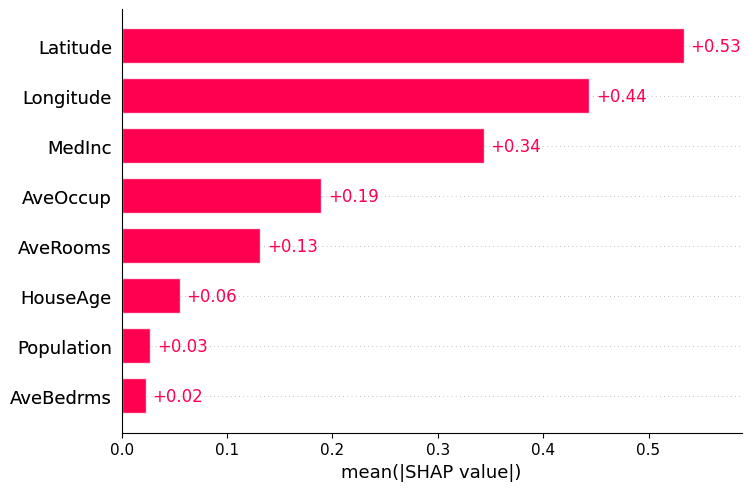

In [24]:
shap.plots.bar(shap_values)